# How much weight can the Tarot T18 handle without crashing?

I will give it a simple task of flying a square trajectory 30m in the air.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog

In [11]:
pid_agent = PIDAgent()

pid_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':10}
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

In [12]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params, mass):
    env = env_selector.get_env("sliding", params, wind_ranges, square_wpts, start_alt=30)
    env.base_env.vehicle.params.mass = mass
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)

    log.done_logging()
    return log, info

In [17]:
def sweep_mass(env_selector, agent, params):
    masses = [x*2 for x in range(1,26)] # 2-50 kg mass
    
    for mass in tqdm(masses):
        log, info = run_trajectory(env_selector, [(0,0),(0,0),(0,0)], agent, params, mass)
        if not info.get('reached'):
            print(f"Failed at {mass} kg")
            print(info)
            return log

    print(f"Can handle {masses[0]} to {masses[-1]} kg")
    return None

In [18]:
failure_log = sweep_mass(env_selector, pid_agent, pid_params)

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 18/25 [01:23<00:32,  4.62s/it]

Failed at 38 kg
{'u': array([100.     , 218.62863,  30.     ,   0.     ,   0.     ,   0.     ],
      dtype=float32), 'dxdt': array([-1.2875e+01,  4.8052e+01, -9.0110e+00, -1.9000e+00,  4.8770e+00,
        4.2360e+00, -3.9000e-02, -6.0000e-03,  1.0000e-03, -0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      dtype=float32), 'reached': False, 'outofbounds': True, 'outoftime': False, 'tipped': False, 'crashed': True}


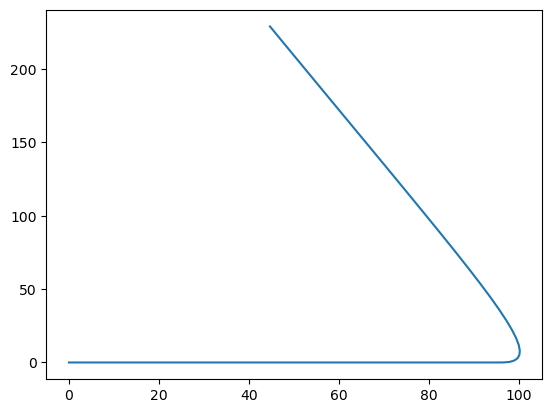

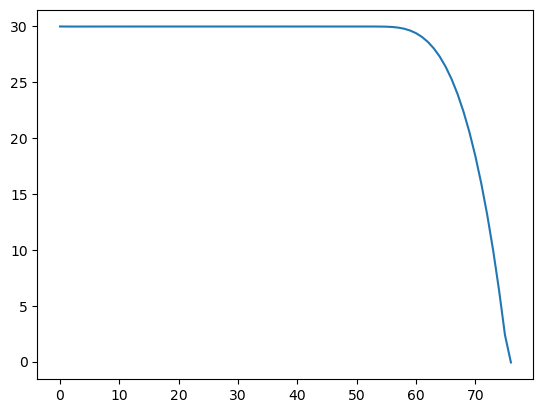

In [19]:
plt.plot(failure_log.x, failure_log.y)
plt.show()

plt.plot(failure_log.z)